In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import gc
import itertools

%matplotlib inline

In [2]:
test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [4]:
train.shape

(2935849, 10)

In [5]:
train[train['shop_id']==1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
41348,2013-01-14,0,1,8070,137.0,1,ЁЛКИ 1+2 (BD),37,"!Якутск ТЦ ""Центральный"" фран",Кино - Blu-Ray
41349,2013-01-20,0,1,11415,70.0,1,"ЕШЬ, МОЛИСЬ, ЛЮБИ (регион)",40,"!Якутск ТЦ ""Центральный"" фран",Кино - DVD
41350,2013-11-01,0,1,11435,110.0,1,ЖЕКА Когда не нужно лишних слов,55,"!Якутск ТЦ ""Центральный"" фран",Музыка - CD локального производства
41351,2013-01-29,0,1,11441,75.0,1,ЖЕЛЕЗНАЯ ЛЕДИ (регион),40,"!Якутск ТЦ ""Центральный"" фран",Кино - DVD
41352,2013-01-20,0,1,11450,249.0,1,ЖЕЛЕЗНЫЙ РЫЦАРЬ,40,"!Якутск ТЦ ""Центральный"" фран",Кино - DVD
...,...,...,...,...,...,...,...,...,...,...
180691,2013-10-02,1,1,4163,1088.0,2,Kaspersky Internet Security 2013 Russian Editi...,75,"!Якутск ТЦ ""Центральный"" фран",Программы - Для дома и офиса
180692,2013-08-02,1,1,4163,1088.0,2,Kaspersky Internet Security 2013 Russian Editi...,75,"!Якутск ТЦ ""Центральный"" фран",Программы - Для дома и офиса
180693,2013-07-02,1,1,4163,1088.0,1,Kaspersky Internet Security 2013 Russian Editi...,75,"!Якутск ТЦ ""Центральный"" фран",Программы - Для дома и офиса
180694,2013-06-02,1,1,4163,1088.0,1,Kaspersky Internet Security 2013 Russian Editi...,75,"!Якутск ТЦ ""Центральный"" фран",Программы - Для дома и офиса


In [6]:
train = train[(train['item_price'] < 50000 ) & (train['item_cnt_day'] < 1000)]
train = train[train['item_price'] > 0]
median = train[(train['shop_id'] == 32)&(train['item_id'] == 2973)&(train['date_block_num'] == 4)&(train['item_price'] > 0)].item_price.median()
train.loc[train['item_price'] < 0, 'item_price'] = median
train.loc[train['item_cnt_day'] < 1, 'item_cnt_day'] = 0

train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]

train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

train.loc[train['shop_id'] == 40, 'shop_id'] = 39
test.loc[test['shop_id'] == 40, 'shop_id'] = 39

In [7]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [8]:
matrix = create_testlike_train(train, test)

In [9]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0
...,...,...,...,...,...
214195,34,45,18454,0.0,0.0
214196,34,45,16188,0.0,0.0
214197,34,45,15757,0.0,0.0
214198,34,45,19648,0.0,0.0


In [10]:
print('lines in train set:', train.shape[0])
print('unique items in train set:', train['item_id'].nunique())
print('unique shops in train set:', train['shop_id'].nunique())
print('lines in test set:', test.shape[0])
print('unique items in test set:', test['item_id'].nunique())
print('unique shops in test set:', test['shop_id'].nunique())
print('-----missing value-----')
print(train.isnull().sum())
print('--------nan value------')
print(train.isna().sum())

lines in train set: 2413241
unique items in train set: 21003
unique shops in train set: 42
lines in test set: 214200
unique items in test set: 5100
unique shops in test set: 42
-----missing value-----
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
item_revenue_day      0
dtype: int64
--------nan value------
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
item_revenue_day      0
dtype: int64


In [11]:
len(train[train.duplicated()])

5

In [12]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [13]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 302.54 MB
Memory usage after optimization is: 151.27 MB
Decreased by 50.0%


In [14]:
import re

from fuzzywuzzy import fuzz


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

C:\Users\JasonChang\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [15]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group
0,0,59,22154,1,999.0,9737
1,0,59,2552,0,0.0,1085
2,0,59,2554,0,0.0,1086
3,0,59,2555,0,0.0,1087
4,0,59,2564,0,0.0,1092
...,...,...,...,...,...,...
8812162,34,45,18454,0,0.0,8148
8812163,34,45,16188,0,0.0,7093
8812164,34,45,15757,0,0.0,6950
8812165,34,45,19648,0,0.0,8708


In [16]:
def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [17]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # Month id feature
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [18]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


In [19]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [20]:
matrix = add_price_features(matrix, train)
del(train)

In [21]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

In [22]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

In [24]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [25]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)



matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [26]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [27]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,item_name_length,item_name_cleaned_length,shop_open_days,item_cnt_day_avg,...,supercategory_id,city_code,name_group_cat_unique_month,name_group_new_unique_month,name_group_new_cat_unique_month,unique_items_cat,new_items_cat,new_items_month,cat_items_proportion,name_group_new_proportion_month
0,0,59,22154,1,999.0,9737,17,13,0,0.002841,...,4,30,1,2,1,595,595,7506,0.079270,1.0
1,0,59,2552,0,0.0,1085,40,38,0,0.000000,...,6,30,1,1,1,133,133,7506,0.017719,1.0
2,0,59,2554,0,0.0,1086,40,38,0,0.000000,...,6,30,1,1,1,133,133,7506,0.017719,1.0
3,0,59,2555,0,0.0,1087,39,32,0,0.000000,...,6,30,2,2,2,87,87,7506,0.011591,1.0
4,0,59,2564,0,0.0,1092,50,43,0,0.000000,...,6,30,1,1,1,148,148,7506,0.019718,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812162,34,45,18454,0,0.0,8148,11,10,1033,0.000000,...,6,21,2,0,0,672,38,384,0.131765,0.0
8812163,34,45,16188,0,0.0,7093,28,27,1033,0.000000,...,0,21,3,0,0,128,11,384,0.025098,0.0
8812164,34,45,15757,0,0.0,6950,34,33,1033,0.000000,...,6,21,1,0,0,672,38,384,0.131765,0.0
8812165,34,45,19648,0,0.0,8708,31,19,1033,0.000000,...,4,21,1,0,0,770,71,384,0.150980,0.0


In [28]:
oldcols

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_revenue_month', 'item_name_group', 'item_name_length',
       'item_name_cleaned_length', 'shop_open_days', 'item_cnt_day_avg',
       'first_item_sale_days', 'first_shop_item_sale_days',
       'first_name_group_sale_days', 'last_shop_item_sale_days', 'month',
       'item_age', 'new_item', 'shop_age', 'last_item_price',
       'last_norm_diff_cat_price', 'item_category_id', 'platform_id',
       'supercategory_id', 'city_code', 'name_group_cat_unique_month',
       'name_group_new_unique_month', 'name_group_new_cat_unique_month',
       'unique_items_cat', 'new_items_cat', 'new_items_month',
       'cat_items_proportion', 'name_group_new_proportion_month'],
      dtype='object')

In [29]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [30]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [31]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [32]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Lag features created


In [33]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_id_item_cnt_day_avg_mean_lag_1
Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1


In [34]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "new_items_cat",
]
matrix = matrix.drop(columns=surplus_columns)

In [35]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33):
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)
        st = re.sub(r"\s{2,}", " ", st)
        st = st.lower().strip()
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords)
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # Made the word counts binary
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JasonChang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


In [37]:
gc.collect()
matrix.to_pickle("checkpoint_final.pkl")
print("All features generated, dataframe saved")
%reset -f

All features generated, dataframe saved


In [38]:
import pandas as pd
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)

In [39]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_name_length,item_name_cleaned_length,first_item_sale_days,first_shop_item_sale_days,first_name_group_sale_days,last_shop_item_sale_days,...,word_контроллер,word_оплаты,word_охота,word_регион,word_русская,word_русские,word_специальное,word_субтитры,word_цифровая,word_черный
0,0,59,22154,1,17,13,9999,9999,9999,9999,...,0,0,0,0,0,0,0,0,0,0
1,0,59,2552,0,40,38,9999,9999,9999,9999,...,0,0,0,0,0,0,0,0,0,0
2,0,59,2554,0,40,38,9999,9999,9999,9999,...,0,0,0,0,0,0,0,0,0,0
3,0,59,2555,0,39,32,9999,9999,9999,9999,...,0,0,0,0,0,0,0,0,0,0
4,0,59,2564,0,50,43,9999,9999,9999,9999,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812162,34,45,18454,0,11,10,323,320,1034,2,...,0,0,0,0,0,0,0,0,0,0
8812163,34,45,16188,0,28,27,47,9999,1033,9999,...,0,0,0,0,0,0,0,0,0,0
8812164,34,45,15757,0,34,33,1024,1010,1033,252,...,0,0,0,0,0,0,0,0,0,0
8812165,34,45,19648,0,31,19,354,9999,354,9999,...,0,0,0,1,0,0,0,0,0,0


In [40]:
keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
test_month = 33
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting

valid = matrix.drop(columns=dropcols).loc[matrix.date_block_num == test_month, :]
train = matrix.drop(columns=dropcols).loc[matrix.date_block_num < test_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
Y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
del matrix

In [41]:
X_train

,date_block_num,item_name_length,item_name_cleaned_length,first_item_sale_days,first_shop_item_sale_days,first_name_group_sale_days,last_shop_item_sale_days,month,last_item_price,last_norm_diff_cat_price,...,word_контроллер,word_оплаты,word_охота,word_регион,word_русская,word_русские,word_специальное,word_субтитры,word_цифровая,word_черный
502154,2,28,28,9999,9999,9999,-47,1,846.169983,0.070759,...,0,0,0,0,0,0,0,0,0,0
502155,2,29,20,9999,9999,9999,9999,1,149.000000,-0.277302,...,0,0,0,1,0,0,0,0,0,0
502156,2,31,24,9999,9999,9999,-54,1,682.869873,0.576632,...,0,0,0,0,0,0,0,0,0,0
502157,2,48,9,9999,9999,9999,-58,1,915.603638,-0.317405,...,0,0,0,0,1,0,0,0,0,0
502158,2,47,22,9999,9999,9999,9999,1,347.157135,0.227751,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8376160,32,26,25,299,9999,326,9999,1,1249.000000,-0.309783,...,0,0,0,0,0,0,0,0,0,0
8376161,32,29,28,266,9999,326,-188,1,1165.666626,-0.355834,...,0,0,0,0,0,0,0,0,0,0
8376162,32,11,7,726,660,726,660,1,199.000000,-0.441833,...,0,0,0,0,0,0,0,0,0,0
8376163,32,29,28,74,9999,326,9999,1,1249.000000,-0.309783,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X_validation = X_valid
Y_validation = y_valid
# Integer features (used by catboost model).
# int_features = ['shop_id', 'item_id', 'year', 'month']
 
# X_train[int_features] = X_train[int_features].astype('int32')
# X_validation[int_features] = X_validation[int_features].astype('int32')

In [43]:
import lightgbm as lgbm

cat_features = [
    "item_category_id",
    "month",
] 
X_train.fillna(X_train.mean(), inplace=True)
X_validation.fillna(X_validation.mean(), inplace=True)
X_train[cat_features].astype("category")
X_validation[cat_features].astype("category")

cat_features = [c for c in cat_features if c in X_train.columns]

lgbm_model = lgbm.LGBMRegressor(num_leaves= 966,
    cat_smooth= 45.01680827234465,
    min_child_samples= 27,
    min_child_weight= 0.021144950289224463,
    max_bin= 214,
    learning_rate= 0.01,
    subsample_for_bin= 300000,
    min_data_in_bin= 7,
    colsample_bytree= 0.8,
    subsample= 0.6,
    subsample_freq= 5,
    n_estimators= 8000,)

lgbm_model.fit(
        X_train,
        Y_train,
        eval_set=[(X_train, Y_train), (X_validation, Y_validation)],
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=cat_features,
        early_stopping_rounds=20,
    )

C:\Users\JasonChang\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\JasonChang\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\JasonChang\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\JasonChang\anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in

[100]	training's rmse: 0.86327	training's l2: 0.745236	valid_1's rmse: 0.861584	valid_1's l2: 0.742328
[200]	training's rmse: 0.759571	training's l2: 0.576948	valid_1's rmse: 0.81952	valid_1's l2: 0.671613
[300]	training's rmse: 0.717444	training's l2: 0.514725	valid_1's rmse: 0.808594	valid_1's l2: 0.653824
[400]	training's rmse: 0.691204	training's l2: 0.477763	valid_1's rmse: 0.805591	valid_1's l2: 0.648977


LGBMRegressor(cat_smooth=45.01680827234465, colsample_bytree=0.8,
              learning_rate=0.01, max_bin=214, min_child_samples=27,
              min_child_weight=0.021144950289224463, min_data_in_bin=7,
              n_estimators=8000, num_leaves=966, subsample=0.6,
              subsample_for_bin=300000, subsample_freq=5)

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

cat_features = [
    "item_category_id",
    "month",
] 
X_train.fillna(X_train.mean(), inplace=True)
X_validation.fillna(X_validation.mean(), inplace=True)
X_train[cat_features].astype("category")
X_validation[cat_features].astype("category")

# rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
#                'item_cnt_mean', 'item_cnt_std', 
#                'shop_mean', 'item_mean', 'mean_item_cnt']
rf_train = X_train
rf_val = X_validation
# rf_test = X_test
 
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)
# 
#Use only part of features on XGBoost.

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [45]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2
test_month = 34
test = matrix.loc[matrix.date_block_num==test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix)
X_test.fillna(X_test.mean(), inplace=True)

In [46]:
from xgboost import XGBRegressor


# X_test[cat_features].astype("category")
# xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
#                 'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
#                 'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train
xgb_val = X_validation
# xgb_test = X_test
 
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

C:\Users\JasonChang\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\JasonChang\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.09479	validation_1-rmse:0.99067
[20]	validation_0-rmse:0.84305	validation_1-rmse:0.84436
[40]	validation_0-rmse:0.81874	validation_1-rmse:0.84157
[60]	validation_0-rmse:0.80384	validation_1-rmse:0.84461
[63]	validation_0-rmse:0.80300	validation_1-rmse:0.84379


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

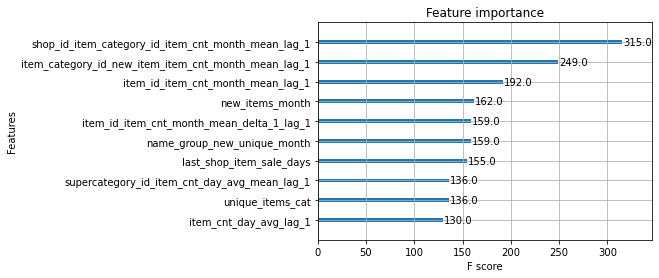

In [47]:
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=10) # top 10 most important features
plt.show()

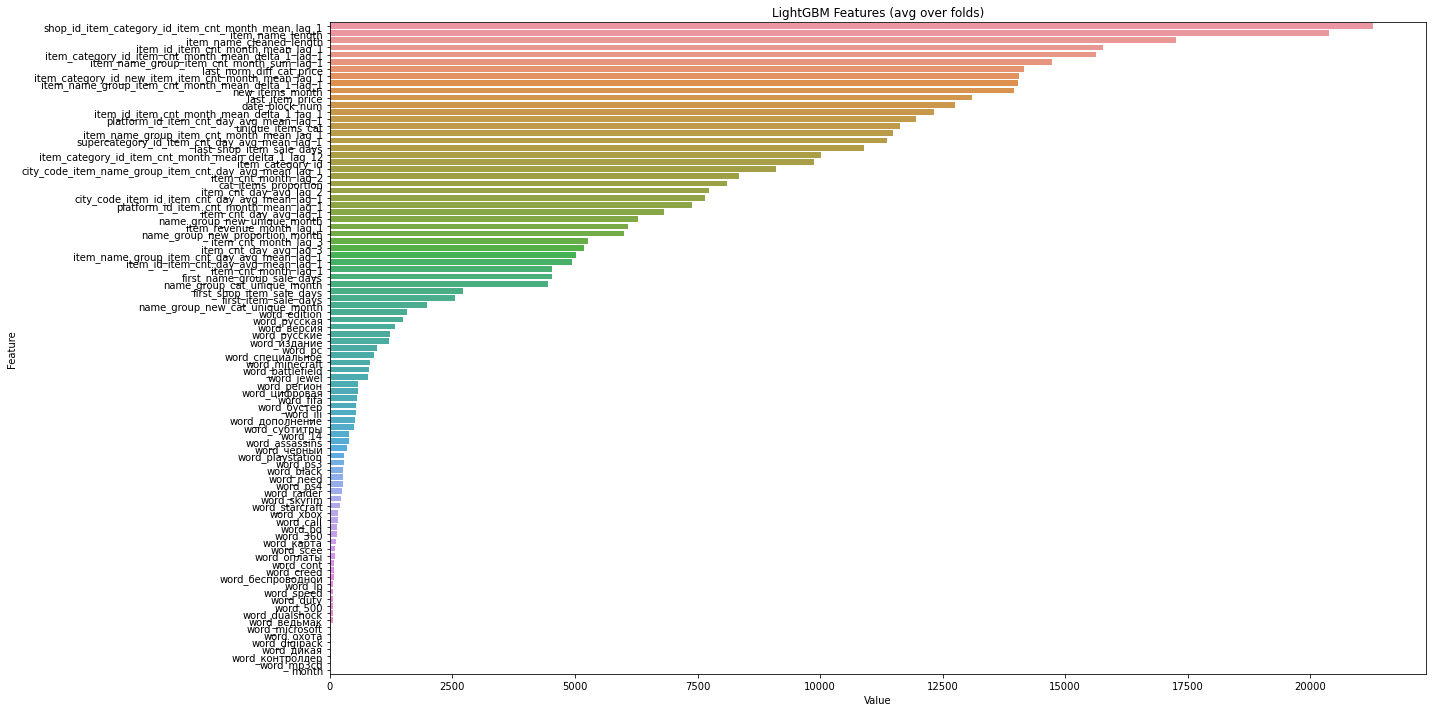

<Figure size 432x288 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [48]:
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
] 
# X_test["item_cnt_month"] = xgb_model.predict(X_test.drop(columns=dropcols)).clip(0, 20)
# # Merge the predictions with the provided template
# test_orig = pd.read_csv("test.csv")
# test = test_orig.merge(
#     X_test[["shop_id", "item_id", "item_cnt_month"]],
#     on=["shop_id", "item_id"],
#     how="inner",
#     copy=True,
# )
# # Verify that the indices of the submission match the original
# assert test_orig.equals(test[["ID", "shop_id", "item_id"]])
# test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

In [49]:
# from sklearn.metrics import accuracy_score
# from catboost import CatBoostRegressor, Pool
# from sklearn.metrics import mean_squared_error

# # cat_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
# #                'item_cnt_mean', 'item_cnt_std', 
# #                'shop_mean', 'item_mean', 'mean_item_cnt']

# cat_features = [
#     "item_category_id",
#     "month",
# ] 
# cat_train = X_train.astype(str)
# print(cat_train)
# cat_val = X_validation.astype(str)
# # cat_test = X_test[cat_features].astype(str)
# catboost_model = CatBoostRegressor(
#     iterations=500,
#     max_ctr_complexity=1,
#     random_seed=0,
#     od_type='Iter',
#     use_best_model=True,
#     od_wait=25,
#     verbose=50,
#     thread_count=-1,
#     allow_writing_files=False,
#     depth=4)
# #训练模型
# catboost_model.fit(
#     cat_train, y_train,
#     cat_features=[7, 10],
#     eval_set=(cat_val, Y_validation))
# # y_pred= catboost_model.predict(cat)


In [50]:
# catboost_score=catboost_model.score(cat_train,Y_train)
# print("catboost算法得分：",catboost_score)

# feature_score = pd.DataFrame(list(zip(X_train.dtypes.index,catboost_model.get_feature_importance())), 
#                              columns=['Feature','Score'])
# feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
# plt.rcParams["figure.figsize"] = (19, 6)
# ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
# ax.set_title("特征重要性分布", fontsize = 14)
# ax.set_xlabel('')
# rects = ax.patches
# labels = feature_score['Score'].round(2)
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')
# plt.show()

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline
cat_features = [
    "item_category_id",
    "month",
] 
X_train.fillna(X_train.mean(), inplace=True)
X_validation.fillna(X_validation.mean(), inplace=True)
X_train[cat_features].astype("category")
X_validation[cat_features].astype("category")

# lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']

lr_train = X_train[:2000000]
lr_val = X_validation[:2000000]
# lr_test = X_test[lr_features]
 
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
# lr_test = lr_scaler.transform(lr_test)
 
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train[:2000000])

LinearRegression(n_jobs=-1)

In [52]:
# # knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
# #                 'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
# #                 'item_trend', 'mean_item_cnt']
 
# # Subsample train set (using the whole data was taking too long).
# X_train_sampled = X_train
# Y_train_sampled = Y_train
 
# knn_train = X_train_sampled
# knn_val = X_validation
# # knn_test = X_test[knn_features]
 
# knn_scaler = MinMaxScaler()
# knn_scaler.fit(knn_train)
# knn_train = knn_scaler.transform(knn_train)
# knn_val = knn_scaler.transform(knn_val)
# # knn_test = knn_scaler.transform(knn_test)
 
# knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
# knn_model.fit(knn_train, Y_train_sampled)

In [59]:
first_level = pd.DataFrame(xgb_model.predict(xgb_val), columns=['xgbm'])
# first_level['catboost']= catboost_model.predict(cat_val)
first_level['random_forest'] = rf_model.predict(rf_val)
# first_level['linear_regression'] = lr_model.predict(lr_val)
first_level['lgbm'] = lgbm_model.predict(X_validation)
first_level['label'] = Y_validation.values
first_level

,xgbm,random_forest,lgbm,label
0,0.006405,0.034356,0.023153,1
1,0.689976,0.542296,0.906895,1
2,0.325636,0.240740,0.398180,2
3,0.136511,0.170514,0.130407,1
4,1.346137,0.899622,0.835953,1
...,...,...,...,...
221797,0.006757,0.148928,0.458373,0
221798,0.022654,0.053112,0.030401,0
221799,-0.028572,0.148928,0.478474,0
221800,0.021783,0.053112,0.034638,0


In [60]:
# first_level_test

In [61]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2
test_month = 34
test = matrix.loc[matrix.date_block_num==test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix)
X_test.fillna(X_test.mean(), inplace=True)

In [62]:
first_level_test = pd.DataFrame(xgb_model.predict(X_test.drop(columns=dropcols)), columns=['xgbm'])
# first_level_test['catboost']= catboost_model.predict(cat_test)
first_level_test['random_forest'] = rf_model.predict(X_test.drop(columns=dropcols))
# first_level_test['linear_regression'] = lr_model.predict(X_test.drop(columns=dropcols))
first_level_test['lgbm'] = lgbm_model.predict(X_test.drop(columns=dropcols))
first_level_test

,xgbm,random_forest,lgbm
0,0.691278,0.471036,0.789739
1,0.767576,1.313271,1.167144
2,0.867005,0.471036,1.213293
3,0.482227,0.417325,0.673859
4,0.637856,4.151120,2.532015
...,...,...,...
214195,0.103994,0.074739,0.091002
214196,0.016709,0.034356,0.031999
214197,0.044562,0.053112,0.054400
214198,-0.001092,0.034356,0.018374


In [63]:
test_orig = pd.read_csv("test.csv")

meta_model = LinearRegression(n_jobs=-1)
 
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)
 
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)
 
prediction_df = pd.DataFrame(test_orig['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.913234
1,1,0.931380
2,2,1.551842
3,3,0.763259
4,4,1.106477
5,5,0.884825
6,6,0.471020
7,7,0.175984
8,8,0.259909
9,9,0.164211


In [67]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth',100)
X_train

,date_block_num,item_name_length,item_name_cleaned_length,first_item_sale_days,first_shop_item_sale_days,first_name_group_sale_days,last_shop_item_sale_days,month,last_item_price,last_norm_diff_cat_price,item_category_id,name_group_cat_unique_month,name_group_new_unique_month,name_group_new_cat_unique_month,unique_items_cat,new_items_month,cat_items_proportion,name_group_new_proportion_month,item_id_item_cnt_month_mean_delta_1_lag_1,item_category_id_item_cnt_month_mean_delta_1_lag_1,item_name_group_item_cnt_month_mean_delta_1_lag_1,item_category_id_item_cnt_month_mean_delta_1_lag_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_day_avg_lag_1,item_cnt_day_avg_lag_2,item_cnt_day_avg_lag_3,item_revenue_month_lag_1,item_name_group_item_cnt_month_mean_lag_1,item_name_group_item_cnt_month_sum_lag_1,item_id_item_cnt_month_mean_lag_1,item_id_item_cnt_day_avg_mean_lag_1,platform_id_item_cnt_day_avg_mean_lag_1,item_name_group_item_cnt_day_avg_mean_lag_1,platform_id_item_cnt_month_mean_lag_1,supercategory_id_item_cnt_day_avg_mean_lag_1,item_category_id_new_item_item_cnt_month_mean_lag_1,shop_id_item_category_id_item_cnt_month_mean_lag_1,city_code_item_id_item_cnt_day_avg_mean_lag_1,city_code_item_name_group_item_cnt_day_avg_mean_lag_1,word_14,word_360,word_500,word_assassins,word_battlefield,word_bd,word_black,word_call,word_cont,word_creed,word_digipack,word_dualshock,word_duty,word_edition,word_fifa,word_iii,word_jewel,word_lp,word_microsoft,word_minecraft,word_mp3cd,word_need,word_pc,word_playstation,word_ps3,word_ps4,word_raider,word_scee,word_skyrim,word_speed,word_starcraft,word_xbox,word_беспроводной,word_бустер,word_ведьмак,word_версия,word_дикая,word_дополнение,word_издание,word_карта,word_контроллер,word_оплаты,word_охота,word_регион,word_русская,word_русские,word_специальное,word_субтитры,word_цифровая,word_черный
502154,2,28,28,9999,9999,9999,-47,1,846.169983,0.070759,69,20,3,3,52,882,0.006612,0.150000,1.079832,-0.018223,-0.062037,0.015601,1.0,0.38217,0.399276,0.002786,0.001199,0.001255,849.000000,0.211397,115.0,0.441176,0.001229,0.001017,0.000587,0.366771,0.000998,0.345842,0.097561,0.002786,0.000712,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502155,2,29,20,9999,9999,9999,9999,1,149.000000,-0.277302,40,1,0,0,2418,882,0.307438,0.000000,-0.552036,-0.074814,-0.738688,0.015601,0.0,0.38217,0.399276,0.000000,0.001199,0.001255,0.000000,0.102941,7.0,0.176471,0.000486,0.000735,0.000318,0.264402,0.000729,0.240473,0.108844,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
502156,2,31,24,9999,9999,9999,-54,1,682.869873,0.576632,37,1,0,0,606,882,0.077050,0.000000,0.244317,0.022647,0.181437,0.015601,3.0,0.38217,0.399276,0.008264,0.001199,0.001255,2097.000000,15.676471,1066.0,13.705882,0.037757,0.000616,0.043186,0.220588,0.000729,0.183589,0.070840,0.008264,0.011019,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502157,2,48,9,9999,9999,9999,-58,1,915.603638,-0.317405,19,3,1,0,230,882,0.029243,0.100000,1.246218,0.145988,3.000000,0.015601,2.0,0.38217,0.399276,0.005510,0.001199,0.001255,1452.849976,10.163399,3110.0,2.382353,0.006545,0.002527,0.027992,0.916380,0.002964,0.951199,0.301802,0.005510,0.008264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
502158,2,47,22,9999,9999,9999,9999,1,347.157135,0.227751,30,2,0,0,356,882,0.045264,0.000000,-0.054954,-0.072708,-0.242874,0.015601,0.0,0.38217,0.399276,0.000000,0.001199,0.001255,0.000000,3.338235,227.0,2.176471,0.005979,0.003037,0.009165,1.101023,0.002964,1.173630,0.544271,0.000000,0.001377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# test_orig = pd.read_csv("test.csv")
# final_predictions = lgbm_model.predict(X_test.drop(columns=dropcols))
# prediction_df = pd.DataFrame(test_orig['ID'], columns=['ID'])
# prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
# prediction_df.to_csv('submission.csv', index=False)